In [1]:
# Load modules
import sys
sys.path.append('../mapplot/')

import matplotlib.pyplot as plt
import numpy as np
import sys
from pathlib import Path
import psyplot.project as psy
import pandas as pd
import xarray
from netCDF4 import Dataset,date2num

from timefunctions import *
import varfunctions as vf
import locfunctions as lf
import datetime as dt

from iconarray.plot import formatoptions # import plotting formatoptions (for use with psyplot)
import iconarray as iconvis # import self-written modules from iconarray

INFO:numexpr.utils:Note: NumExpr detected 36 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
INFO:numexpr.utils:NumExpr defaulting to 8 threads.


In [2]:
###############################################################################################
## CONSTANT FILE  ##
c_filename = "lfff00000000c.nc"
filepath = '/store/s83/swester/teamx/tdf_2019091212/output/19091212/'
const_file = filepath + c_filename
data_c = psy.open_dataset(const_file)

###############################################################################################
## DECIDE ##
# where to save
plotpath_base = '/scratch/tlezuo/icon-vis/lidar/data/'
# decide which locations to calculate
loc_list = []
# loc_list.extend([])
loc_list=[lf.kols]

# decide which variables to calculate
pvars_list = []
cvars_list = []
# pvars_list.extend([vf.qv_2m,vf.T_2M])
pvars_list= [vf.U, vf.V, vf.T, vf.QV,vf.P]
cvars_list = [vf.VEL, vf.DIR]

# decide which time period to plot
simdate = dt.datetime(2019,9,12,12,00) # no change,. simulation start
startdate = dt.datetime(2019,9,13,00,00)
enddate = dt.datetime(2019,9,14,00,00)
plotfreq = '0h30min'
plotdates = pd.date_range(startdate,enddate,freq=plotfreq)



# TEST
plotdate = dt.datetime(2019,9,13,8,30)
simdate = dt.datetime(2019,9,12,12,00)
lt = get_lt(plotdate,simdate)

print(lt)
filename = lfff_name(lt)
nc_file = '/store/s83/swester/teamx/tdf_2019091212/output/19091212/'+filename
# If necessary, add the corresponding grid file:
grid_file = '../data/example_data/grids/ICON-1E_DOM01.nc'

if iconvis.check_grid_information(nc_file):
    print('The grid information is available')
    data = psy.open_dataset(nc_file)
else:
    print('The grid information is not available')
    data = iconvis.combine_grid_information(nc_file,grid_file)

print(filename)

20.5
The grid information is available
lfff00203000.nc


In [3]:
###############################################################################################
## PLOT SETUP ##
# loop 1 over locations
for loc in loc_list:
    # get closest point
    lats = np.rad2deg(data.clat.values[:])
    lons = np.rad2deg(data.clon.values[:])
    ind = iconvis.ind_from_latlon(lats,lons,loc.lat,loc.lon,verbose=True)

    # initialize lidar dataset for this location
    lidar_data = {}
    for pvar in pvars_list:
        lidar_data[pvar.name] = np.zeros((len(plotdates),80)) # 81 levels for halflevel-variables as W
    for cvar in cvars_list:
        lidar_data[cvar.name] = np.zeros((len(plotdates),80)) # 81 levels for halflevel-variables as W

    # path sepcific to location
    plotpath = plotpath_base
    Path(plotpath).mkdir(parents=True, exist_ok=True)

    # loop 2 over time
    for counter,pdate in enumerate(plotdates):
        print('    calculating lidar at ' + loc.name + pdate.strftime('%Y/%m/%d at %H:%M'))
        ## READ IN ##
        lt = get_lt(pdate,simdate) # get leadtime
        filename = lfff_name(lt) # get filename
        nc_file = filepath+filename
        # If necessary, add the corresponding grid file:
        grid_file = '/store/s83/swester/teamx/grid_R19B08_size_cosmo1/d01_DOM01.nc'

        if iconvis.check_grid_information(nc_file):
            # print('             The grid information is available')
            data = psy.open_dataset(nc_file)
        else:
            print('             The grid information is not available')
            data = iconvis.combine_grid_information(nc_file,grid_file)

        # select variables from data dataset
        for pvar in pvars_list:
            # print(pvar.name)
            lidar_data[pvar.name][counter] = data[pvar.name][0,:,ind].data.squeeze()[::-1] # reverse the variable arrays to have L 81 data at bottom

        # add height
        lidar_data['height'] = data['height_3'].data.squeeze()[::-1] # reverse the height to have 81 at bottom

        ## CALCULATE NEW VARS ##
        for cvar in cvars_list:
            # VEL
            if cvar.name == 'VEL':
                lidar_data[cvar.name][counter] = vf.calculate_wind_vel_from_uv(lidar_data['U'][counter],lidar_data['V'][counter])
                # lidar_data[cvar.name][counter] = lidar_data[cvar.name][counter][::-1]
            # DIR
            elif cvar.name == 'DIR':
                lidar_data[cvar.name][counter] = vf.calculate_wind_dir_from_uv(lidar_data['U'][counter],lidar_data['V'][counter],modulo_180=False)
            # TH 
            elif cvar.name == 'TH':
                lidar_data[cvar.name][counter] = vf.calculate_potT(lidar_data['T'][counter],lidar_data['P'][counter])
    ## SAVE lidar_data ##
    np.save('lidar_data_'+loc.name+'.npy', lidar_data) 

Closest ind: 810552
 Given lat: 47.305 vs found lat: 47.307
 Given lon: 11.622 vs found lon: 11.620
    calculating lidar at Kolsass2019/09/13 at 00:00
    calculating lidar at Kolsass2019/09/13 at 00:30
    calculating lidar at Kolsass2019/09/13 at 01:00
    calculating lidar at Kolsass2019/09/13 at 01:30
    calculating lidar at Kolsass2019/09/13 at 02:00
    calculating lidar at Kolsass2019/09/13 at 02:30
    calculating lidar at Kolsass2019/09/13 at 03:00
    calculating lidar at Kolsass2019/09/13 at 03:30
    calculating lidar at Kolsass2019/09/13 at 04:00
    calculating lidar at Kolsass2019/09/13 at 04:30
    calculating lidar at Kolsass2019/09/13 at 05:00
    calculating lidar at Kolsass2019/09/13 at 05:30
    calculating lidar at Kolsass2019/09/13 at 06:00
    calculating lidar at Kolsass2019/09/13 at 06:30
    calculating lidar at Kolsass2019/09/13 at 07:00
    calculating lidar at Kolsass2019/09/13 at 07:30
    calculating lidar at Kolsass2019/09/13 at 08:00
    calculating 

In [6]:

read_dictionary = np.load('lidar_data_'+loc.name+'.npy',allow_pickle='TRUE').item()

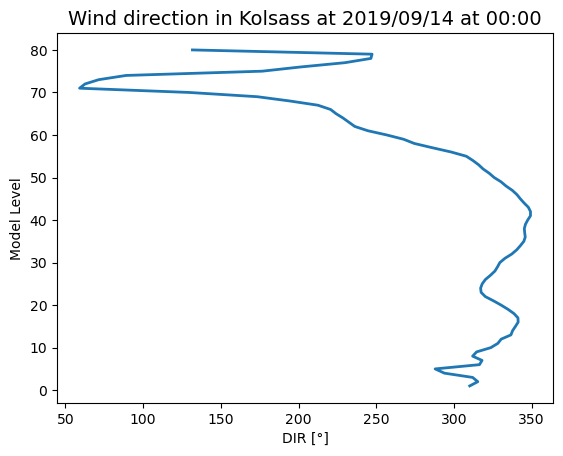

In [8]:
## PLOT SINGLE PROFILE ##
pvar=vf.DIR

# Create plot of var_coord
f, axes = plt.subplots(1,1)                                                                                              
ax = axes                                                                                                                
h = ax.plot(lidar_data[pvar.name][0,:],  lidar_data['height'], lw=2)
ax.set_xlabel(pvar.name+' '+pvar.units)
ax.set_ylabel('Model Level')
ax.set_title(pvar.title+' in '+loc.name + ' at ' +pdate.strftime('%Y/%m/%d at %H:%M'), fontsize=14)
# plt.ylim([0,20])
# plt.xlim([pvar.min,pvar.max]);
plt.show()

Text(0, 0.5, 'VEL [m/s]')

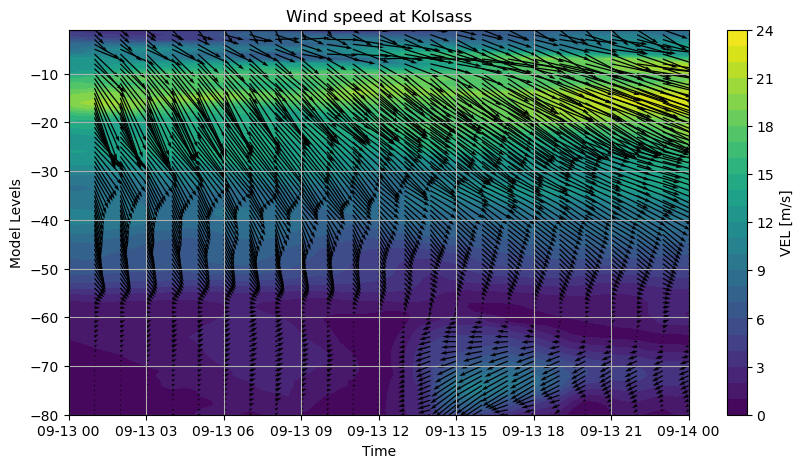

In [5]:
## PLOT LIDAR PLOT ##
# select variable
pvar=vf.VEL

# set data
x = plotdates
y = -lidar_data['height']
z = np.transpose(lidar_data[pvar.name])
levels = np.arange(pvar.min,pvar.max,pvar.ticks)
levels = np.arange(pvar.min,25,pvar.ticks)

#create plot
fig, ax = plt.subplots(1,1, figsize=(10,5))
plt.contourf(x,y,z, levels = levels)
cbar = plt.colorbar()
# add windbarbs
dx = 2
dy =1
q_scale = 30
q_width = 0.002
ax.quiver(x[2::dx], y[::dy], 
        np.transpose(lidar_data['U'])[::dy, 2::dx], #U
        np.transpose(lidar_data['V'])[::dy, 2::dx], #V
        scale=q_scale, scale_units='inches',
        width=q_width)

# plotting options
# ax.set_ylim(0,50) # lowest 30 levels
ax.grid()
ax.set_title(pvar.title+' at '+loc.name)
ax.set_xlabel('Time')
ax.set_ylabel('Model Levels')
cbar.ax.set_ylabel(pvar.name + ' ' + pvar.units)